In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import xgboost
import pickle
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
import shap
from sklearn.linear_model import ElasticNet, LogisticRegression
import matplotlib.pylab as plt
import random

In [101]:
def label_all(permth, mortstat, time):
    if permth > time:
        return 0
    else:
        if mortstat == 1:
            return 1
        else:
            return 2

In [102]:
# def val_mortality_model(age_train, age_val, age_test, train_label, val_label, test_label):
def val_mortality_model(age_train, age_test, train_label, test_label):
    age_train = np.array(age_train)
    # age_val = np.array(age_val)
    age_test = np.array(age_test)
    age_train = age_train[train_label!=2]
    train_label = train_label[train_label!=2]
    # age_val = age_val[val_label!=2]
    # val_label = val_label[val_label!=2]
    age_test = age_test[test_label!=2]
    test_label = test_label[test_label!=2]
    # ### linear model
    model_mort_linear = None
    # print('linear model')
    # model_mort_linear = LogisticRegression().fit(age_train.reshape(len(age_train), -1), train_label)
    # pre = model_mort_linear.predict_proba(age_test.reshape(len(age_test), -1))
    # print('AUC on test set: ', roc_auc_score(test_label, pre[:,1]))
    print('xgboost')
    model_mort_xgb = xgboost.XGBClassifier().fit(age_train.reshape(len(age_train), -1), train_label)
    # model_mort_xgb = xgboost.XGBClassifier(learning_rate=0.01, n_estimators=1000).fit(age_train, train_label, eval_set = [(age_val, val_label)], early_stopping_rounds=100, verbose=False)
    pre = model_mort_xgb.predict_proba(age_test.reshape(len(age_test), -1))
    print('AUC on test set: ', roc_auc_score(test_label, pre[:,1]))
    return model_mort_linear, model_mort_xgb

In [103]:
def bootstrap_ci(y_pre, y_label, sample_size, repetitions = 1000, alpha = 0.05, metric='AUC'): 
    y_pre = np.array(y_pre)
    y_label = np.array(y_label)
    
    res = []
    y_pre = y_pre[y_label!=2]
    y_label = y_label[y_label!=2]
    for i in range(repetitions):
        np.random.seed(i)
        idx = list(np.random.choice(len(y_pre), replace = True, size = sample_size))
        y_pre_bootstrap = y_pre[idx]
        y_label_bootstrap = y_label[idx]
        if metric == 'AUC':
            res.append(roc_auc_score(y_label_bootstrap, y_pre_bootstrap))
        elif metric == 'AP':
            res.append(average_precision_score(y_label_bootstrap, y_pre_bootstrap))
    # confidence interval
    left_res = np.percentile(res, alpha/2*100)
    right_res = np.percentile(res, 100-alpha/2*100)
    # point estimate
    print('average '+metric, np.mean(res))
    print((1-alpha)*100,'%','confidence interval for the '+metric+':', (round(left_res,4), round(right_res,4)))
    return res, left_res, right_res

In [104]:
### Original unit:
# Albumin: g/L
# Creatinine: umol/L
# Glucose, serum: mmol/L
# C-reactive protein (log): mg/L 
# Lymphocyte percent: %
# Mean cell volume: fL
# Red cell distribution width: %
# Alkaline phosphatase: U/L
# White blood cell count: 10^9 cells/L
def calculate_PhenoAge(data):
    change_name_dict = {
    '30600-0.0': 'Albumin',  # g/L
    '30700-0.0': 'Creatinine',  # umol/L
    '30740-0.0': 'Glucose, serum',  # mmol/L
    '30710-0.0': 'C-reactive protein (log)',  #mg/L
    '30180-0.0': 'Lymphocyte percent',  # %
    '30040-0.0': 'Mean cell volume',  # fL
    '30070-0.0': 'Red cell distribution width',  # %
    '30610-0.0': 'Alkaline phosphatase',  # U/L
    '30000-0.0': 'White blood cell count',  # 10^9 cells/L
                       }
    data['flag'] = 1
    for fea in change_name_dict:
        data.loc[data[fea]<0, 'flag'] = 0
    data = data.rename(change_name_dict, axis=1)
    data['C-reactive protein (log)'] = np.log(data['C-reactive protein (log)']/10)
    weights = np.array([-0.0336, 0.0095, 0.1953, 0.0954, -0.0120, 0.0268, 0.3306, 0.0019, 0.0554, 0.0804])
    constant = -19.9067
    gamma = 0.0077
    # for fea in ['Albumin', 'Creatinine', 'Glucose, serum',
    #        'C-reactive protein (log)', 'Lymphocyte percent', 'Mean cell volume',
    #        'Red cell distribution width', 'Alkaline phosphatase',
    #        'White blood cell count']:
    #     data.loc[data[fea]<np.percentile(data[fea], 1), fea] = np.percentile(data[fea], 1)
    #     data.loc[data[fea]>np.percentile(data[fea], 99), fea] = np.percentile(data[fea], 99)                 
    features = np.array(data[['Albumin', 'Creatinine', 'Glucose, serum',
           'C-reactive protein (log)', 'Lymphocyte percent', 'Mean cell volume',
           'Red cell distribution width', 'Alkaline phosphatase',
           'White blood cell count', 'Age']])
    mortality_risk = 1-np.exp(-np.exp(np.sum(weights*features, axis=1)+constant)*(np.exp(120*gamma)-1)/gamma)
    data['PhenoAge'] = 141.50225 + (np.log(-0.00553 * np.log(1-mortality_risk)))/0.090165
    data['PhenoAge_acc'] = data['PhenoAge']-data['Age']
    return data['PhenoAge'], data['PhenoAge_acc']

In [105]:
### Original unit:
# Albumin: g/dL
# Alkaline phosphatase: U/L
# Creatinine: mg/dL
# C-reactive protein: mg/dL
# Hba1c: %
# Systolic BP: mmHg
# Total Cholesterol: mg/dL
def calculate_BioAge(data):
    change_name_dict = {
    '30600-0.0': 'Albumin',  # g/L
    '30610-0.0': 'Alkaline phosphatase',  # U/L
    '30700-0.0': 'Creatinine',  # umol/L
    '30710-0.0': 'C-reactive protein',  # mg/L
    '30750-0.0': 'Hba1c',  # mmol/mol
    '93-0.0': 'Systolic BP',  # mmHg
    '30690-0.0': 'Total Cholesterol'  # mmol/L
                       }
    data['flag'] = 1
    for fea in change_name_dict:
        data.loc[data[fea]<0, 'flag'] = 0
    data = data.rename(change_name_dict, axis=1)
    data['Albumin'] = data['Albumin']/10
    data['Creatinine'] = data['Creatinine']*0.0113
    data['C-reactive protein'] = data['C-reactive protein']/10
    data['Hba1c'] = (0.09148*data['Hba1c']) + 2.152
    data['Total Cholesterol'] = data['Total Cholesterol']*38.665
    # biological age
    S = [0.3372441, 28.91255, 0.206529, 0.6014597, 0.9468073, 14.64641, 39.93671]
    K = [-0.0057658, 0.4822007, 0.0029099, 0.0058188, 0.0196594, 0.6784407, 0.972077]
    Q = [4.437681, 58.87995, 0.9299351, 0.1414078, 4.488046, 90.98659, 163.2156]
    # for fea in ['Albumin', 'Alkaline phosphatase', 'Creatinine',
    #        'C-reactive protein', 'Hba1c', 'Systolic BP',
    #        'Total Cholesterol']:
    #     data.loc[data[fea]<np.percentile(data[fea], 1), fea] = np.percentile(data[fea], 1)
    #     data.loc[data[fea]>np.percentile(data[fea], 99), fea] = np.percentile(data[fea], 99)  
    features = np.array(data[['Albumin', 'Alkaline phosphatase', 'Creatinine',
           'C-reactive protein', 'Hba1c', 'Systolic BP',
           'Total Cholesterol']])
    k_to_s2 = [k/(s**2) for (k,s) in zip(K, S)]
    k_to_w_sum = np.sum([(k/s)**2 for (k,s) in zip(K, S)])
    data['sum']=np.sum((features-Q)*k_to_s2, axis=1)
    data['BioAge'] = (data['sum']+data['Age']/31.63)/(k_to_w_sum+1/31.63)
    data['BioAge_acc'] = data['BioAge']-data['Age']
    return data['BioAge'], data['BioAge_acc']

In [106]:
def calculate_EXPECTAge(data, path, gender, gender_feature, gender_index):
    model_path = path+'/model.pickle.dat'
    model_train = pickle.load(open(model_path, "rb"))
    data = data.loc[data[gender_feature]==gender_index]
    shap_age_obj = pickle.load(open(path+'/different_age_background/'+gender+'/'+'SHAP_age_exponential'+'/'+'shap_age_object.pkl', 'rb'))
    fore_prediction = model_train.predict(data.loc[:, model_train.get_booster().feature_names], output_margin=True)
    data.loc[:, 'shap_age'] = np.array([shap_age_obj.get_shap_age(fore_prediction[i]) for i in range(len(fore_prediction))])
    data.loc[:, 'shap_age_acc'] = data['shap_age']-data['Age']
    return data['shap_age'], data['shap_age_acc']

In [107]:
def mortality_prediction(bio_age_feature, X_train, train_label_5, train_label_10, X_test, test_label_5, test_label_10, X_valid, valid_label_5, valid_label_10):
    if bio_age_feature == 'Age':
        feature_list = ['Age', '31-0.0']
    else:
        feature_list = [bio_age_feature, 'Age', '31-0.0']
    train_label_5_temp = train_label_5[(X_train[bio_age_feature]!=np.inf) & (X_train[bio_age_feature]!=-np.inf) & (X_train[bio_age_feature].isnull()==False)]
    train_label_10_temp = train_label_10[(X_train[bio_age_feature]!=np.inf) & (X_train[bio_age_feature]!=-np.inf) & (X_train[bio_age_feature].isnull()==False)]
    X_train_temp = X_train[(X_train[bio_age_feature]!=np.inf) & (X_train[bio_age_feature]!=-np.inf) & (X_train[bio_age_feature].isnull()==False)]
    year = 5
    print('5-year')
    # val_label_5_temp = val_label_5[X_val['shap_age']!=np.inf]
    # X_val = X_val[X_val['shap_age']!=np.inf]
    # 5-year mortality, chronological age + biological age acc + Gender
    # _, xgb_model = val_mortality_model(X_train_temp[feature_list], X_val_temp[feature_list], X_test_temp[feature_list], train_label_5_temp, val_label_5_temp, test_label_5_temp)
    _, xgb_model = val_mortality_model(X_train_temp[feature_list], X_test[feature_list], train_label_5_temp, test_label_5)
    print('Test set bootstrap:')
    res, left_res, right_res = bootstrap_ci(xgb_model.predict_proba(np.array(X_test[feature_list]))[:, 1], test_label_5, len(X_test), repetitions = 1000, alpha = 0.05, metric='AUC')
    res_test_5_year = {'res': res, 'left_res': left_res, 'right_res': right_res}
    print('GeoValidation set bootstrap:')
    res, left_res, right_res = bootstrap_ci(xgb_model.predict_proba(np.array(X_valid[feature_list]))[:, 1], valid_label_5, len(X_valid), repetitions = 1000, alpha = 0.05, metric='AUC')
    res_valid_5_year = {'res': res, 'left_res': left_res, 'right_res': right_res}

    year = 10
    print('10-year')
    # val_label_5_temp = val_label_5[X_val['shap_age']!=np.inf]
    # X_val = X_val[X_val['shap_age']!=np.inf]
    # 5-year mortality, chronological age + biological age acc + Gender
    # _, xgb_model = val_mortality_model(X_train_temp[feature_list], X_val_temp[feature_list], X_test_temp[feature_list], train_label_5_temp, val_label_5_temp, test_label_5_temp)
    _, xgb_model = val_mortality_model(X_train_temp[feature_list], X_test[feature_list], train_label_10_temp, test_label_10)
    print('Test set bootstrap:')
    res, left_res, right_res = bootstrap_ci(xgb_model.predict_proba(np.array(X_test[feature_list]))[:, 1], test_label_10, len(X_test), repetitions = 1000, alpha = 0.05, metric='AUC')
    res_test_10_year = {'res': res, 'left_res': left_res, 'right_res': right_res}
    print('GeoValidation set bootstrap:')
    res, left_res, right_res = bootstrap_ci(xgb_model.predict_proba(np.array(X_valid[feature_list]))[:, 1], valid_label_10, len(X_valid), repetitions = 1000, alpha = 0.05, metric='AUC')
    res_valid_10_year = {'res': res, 'left_res': left_res, 'right_res': right_res}
    return res_test_5_year, res_valid_5_year, res_test_10_year, res_valid_10_year

In [108]:
result = {}

# read data

In [109]:
mortality = 'all-cause'
age_feature = 'Age'
gender_feature = '31-0.0'
random_state = 528

In [110]:
data = pd.read_csv('/projects/leelab/nobackup/wqiu/UK_Biobank_genetic_data/pheno_data/features_initial_preprocessing_missforest_imputed_no_missing_lancet_and_meaningful_adjusted_assays_remove20002and20004_AgeAdjusted_CancerAdjusted_geo.csv')
target = pd.read_csv('/projects/leelab/nobackup/wqiu/UK_Biobank_genetic_data/pheno_data/death_label_new.csv')
data = pd.merge(data, target[['eid', 'alive_year', 'all-cause', 'neoplasms', 'circulatory', 'respiratory', 'digestive', 'external',
       'other']], how='right', on='eid')

In [111]:
X = data.copy()
X = X[(X[age_feature]>=39.5) & (X[age_feature]<=70.5)].reset_index(drop=True)  
X = X[(X['external']!=1)]
X = X[(X['all-cause']==0) | (X[mortality]==1)]
X_geo = X.loc[(X['54-0.0']==11004) | (X['54-0.0']==11005)].reset_index(drop=True)
X = X.loc[(X['54-0.0']!=11004) & (X['54-0.0']!=11005)].reset_index(drop=True)
mortstat = X['all-cause'].reset_index(drop=True)
permth_int = X['alive_year'].reset_index(drop=True)
mortstat_geo = X_geo[mortality].reset_index(drop=True)
permth_int_geo = X_geo['alive_year'].reset_index(drop=True)

# Calculate age

## PhenoAge

In [112]:
X['PhenoAge'], X['PhenoAge_acc'] = calculate_PhenoAge(X)
X_geo['PhenoAge'], X_geo['PhenoAge_acc'] = calculate_PhenoAge(X_geo)

invalid value encountered in log
divide by zero encountered in log


In [113]:
selected_idx = random.sample([i for i in range(len(X))], 50000)
data_no_missing_temp = X.loc[selected_idx]
data_no_missing_temp = data_no_missing_temp[data_no_missing_temp['flag']==1]
data_no_missing_temp = data_no_missing_temp[data_no_missing_temp['PhenoAge']!=np.inf]

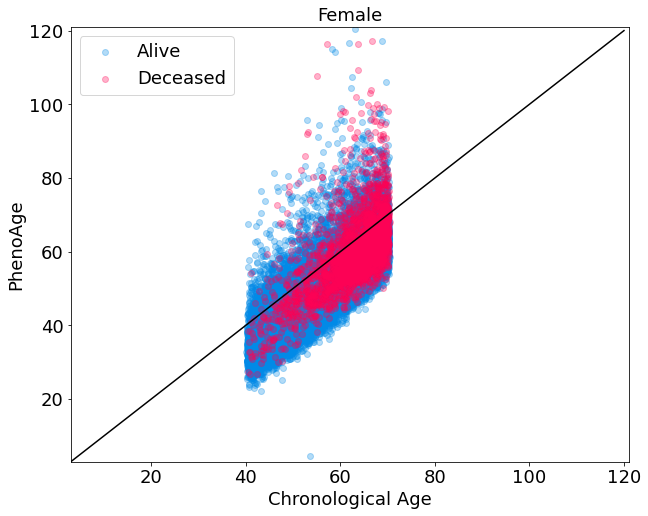

In [114]:
plt.figure(figsize=(10,8))
plt.scatter(np.array(data_no_missing_temp['Age'])[data_no_missing_temp['all-cause'] == 0], np.array(data_no_missing_temp['PhenoAge'])[data_no_missing_temp['all-cause'] == 0], alpha=0.3, color='#018ae7', label='Alive')
plt.scatter(np.array(data_no_missing_temp['Age'])[data_no_missing_temp['all-cause'] == 1], np.array(data_no_missing_temp['PhenoAge'])[data_no_missing_temp['all-cause'] == 1], alpha=0.3, color='#ff0255', label='Deceased')
# plot2 = plt.plot(age_list_f, base_value_list_f, 'black')
# plot3 = plt.plot(age_list_f, up_list_f, 'black')
# plot3 = plt.plot(age_list_f, mid_list_f, 'orange', label='Median values')
# plot3 = plt.plot(age_list_f, down_list_f, 'black')
low = int(data_no_missing_temp['PhenoAge'].min())-1
high = int(data_no_missing_temp['PhenoAge'].max()+1)
plot3 = plt.plot(list(range(low, high)), list(range(low, high)), 'black')
plt.ylabel('PhenoAge')
plt.xlabel('Chronological Age')
plt.xlim(low, high)
plt.ylim(low, high)
plt.legend() #指定legend的位置右下角
plt.title('Female', fontsize=18)
plt.tick_params(axis='both',which='major',labelsize=18)
plt.rc('axes', labelsize=18)
plt.rc('legend', fontsize=18)
plt.show()

0.9955335469463055
0.9935628596508339
0.9933248257583194
0.9912046644925387
0.9922233300099701
0.9907556270096463
0.9896551724137931
0.9890346382455422
0.98611542845301
0.9872859094252391
0.9828115408225906
0.9681050656660413
0.9317507418397626


Text(0.5, 1.0, 'PhenoAge: survival probability')

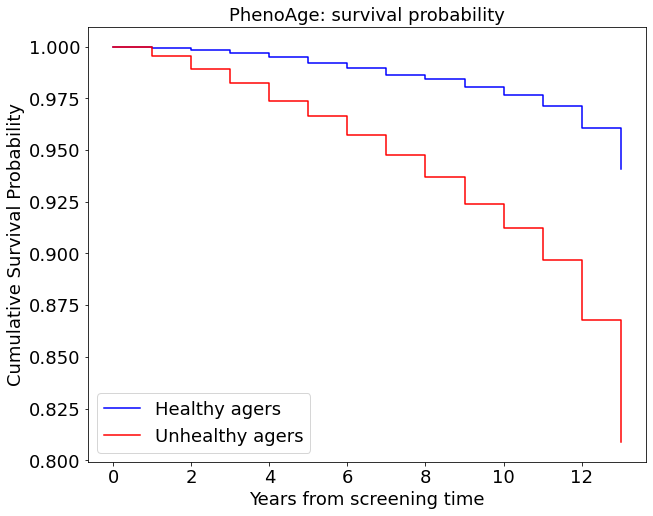

In [115]:
year_num = 13
age = np.array(data_no_missing_temp['Age'])
shap_age = np.array(data_no_missing_temp['PhenoAge'])

permth_int = np.array(data_no_missing_temp['alive_year'])
mortstat = np.array(data_no_missing_temp['all-cause'])
age_acc = shap_age - age
up_value = np.quantile(age_acc, 0.75)
down_value = np.quantile(age_acc, 0.25)
unhealthy_index = [i for i in range(len(age)) if (age_acc[i] >= up_value)]
healthy_index = [i for i in range(len(age)) if (age_acc[i] <= down_value)]
# unhealthy_index = [i for i in range(len(age)) if (shap_age[i] > age[i])]
# healthy_index = [i for i in range(len(age)) if (shap_age[i] <= age[i])]
unhealthy_surv_prob = [1]
for i in range(1, year_num+1):
    label_temp = np.array([label_all(permth_int[j], mortstat[j], i) for j in unhealthy_index])
    label_temp_pre = np.array([label_all(permth_int[j], mortstat[j], (i-1)) for j in unhealthy_index])
    num_samples = sum(label_temp==0)+sum(label_temp==1)-sum(label_temp_pre==1)
    unhealthy_surv_prob.append((sum(label_temp==0)/num_samples)*unhealthy_surv_prob[-1])
    print((sum(label_temp==0)/num_samples))
healthy_surv_prob = [1]
for i in range(1, year_num+1):
    label_temp = np.array([label_all(permth_int[j], mortstat[j], i) for j in healthy_index])
    label_temp_pre = np.array([label_all(permth_int[j], mortstat[j], (i-1)) for j in healthy_index])
    num_samples = sum(label_temp==0)+sum(label_temp==1)-sum(label_temp_pre==1)
    healthy_surv_prob.append((sum(label_temp==0)/num_samples)*healthy_surv_prob[-1])
#             print((sum(label_temp==0)/num_samples))
plt.figure(figsize=(10,8))
plt.step([i for i in range(year_num+1)], healthy_surv_prob, 'blue',label='Healthy agers', where="post")
plt.step([i for i in range(year_num+1)], unhealthy_surv_prob, 'r',label='Unhealthy agers', where="post")
plt.xlabel('Years from screening time', fontsize=18)
plt.ylabel('Cumulative Survival Probability', fontsize=18)
plt.tick_params(axis='both',which='major',labelsize=18)
plt.rc('axes', labelsize=18)
plt.rc('legend', fontsize=18)
plt.legend()
plt.title('PhenoAge: survival probability', fontsize=18)

## BioAge

In [116]:
X['BioAge'], X['BioAge_acc'] = calculate_BioAge(X)
X_geo['BioAge'], X_geo['BioAge_acc'] = calculate_BioAge(X_geo)

In [117]:
selected_idx = random.sample([i for i in range(len(X))], 50000)
data_no_missing_temp = X.loc[selected_idx]
data_no_missing_temp = data_no_missing_temp[data_no_missing_temp['flag']==1]
data_no_missing_temp = data_no_missing_temp[data_no_missing_temp['BioAge']!=np.inf]

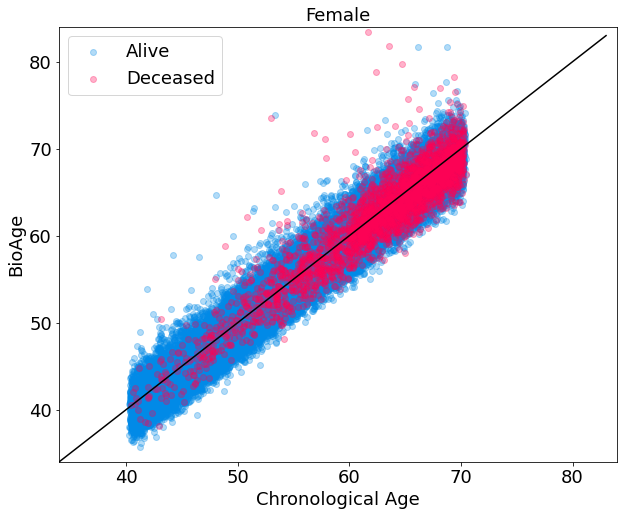

In [118]:
plt.figure(figsize=(10,8))
plt.scatter(np.array(data_no_missing_temp['Age'])[data_no_missing_temp['all-cause'] == 0], np.array(data_no_missing_temp['BioAge'])[data_no_missing_temp[mortality] == 0], alpha=0.3, color='#018ae7', label='Alive')
plt.scatter(np.array(data_no_missing_temp['Age'])[data_no_missing_temp['all-cause'] == 1], np.array(data_no_missing_temp['BioAge'])[data_no_missing_temp[mortality] == 1], alpha=0.3, color='#ff0255', label='Deceased')
# plot2 = plt.plot(age_list_f, base_value_list_f, 'black')
# plot3 = plt.plot(age_list_f, up_list_f, 'black')
# plot3 = plt.plot(age_list_f, mid_list_f, 'orange', label='Median values')
# plot3 = plt.plot(age_list_f, down_list_f, 'black')
low = int(data_no_missing_temp['BioAge'].min())-1
high = int(data_no_missing_temp['BioAge'].max()+1)
plot3 = plt.plot(list(range(low, high)), list(range(low, high)), 'black')
plt.ylabel('BioAge')
plt.xlabel('Chronological Age')
plt.xlim(low, high)
plt.ylim(low, high)
plt.legend() #指定legend的位置右下角
plt.title('Female', fontsize=18)
plt.tick_params(axis='both',which='major',labelsize=18)
plt.rc('axes', labelsize=18)
plt.rc('legend', fontsize=18)
plt.show()

0.9973139673696777
0.9948129675810474
0.9966910658778703
0.9937625754527163
0.9963555375582102
0.9931924405608616
0.9923273657289002
0.9937113402061856
0.9907666770411868
0.9920418848167539
0.9890239584562729
0.9839889306186993
0.9431486880466472


Text(0.5, 1.0, 'PhenoAge: survival probability')

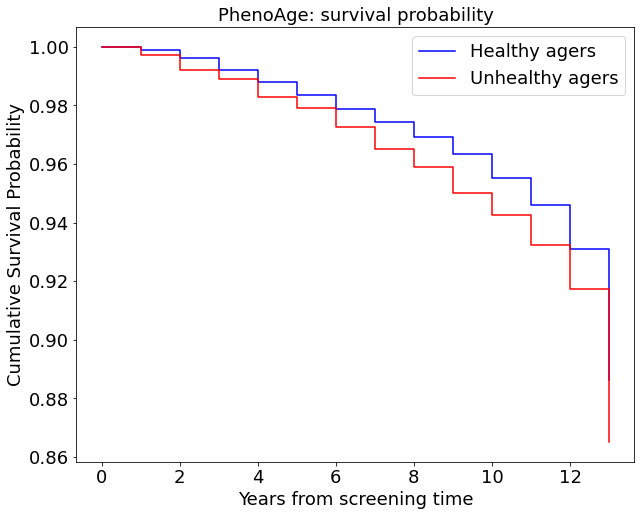

In [119]:
year_num = 13
age = np.array(data_no_missing_temp['Age'])
shap_age = np.array(data_no_missing_temp['BioAge'])

permth_int = np.array(data_no_missing_temp['alive_year'])
mortstat = np.array(data_no_missing_temp[mortality])
age_acc = shap_age - age
up_value = np.quantile(age_acc, 0.75)
down_value = np.quantile(age_acc, 0.25)
unhealthy_index = [i for i in range(len(age)) if (age_acc[i] >= up_value)]
healthy_index = [i for i in range(len(age)) if (age_acc[i] <= down_value)]
# unhealthy_index = [i for i in range(len(age)) if (shap_age[i] > age[i])]
# healthy_index = [i for i in range(len(age)) if (shap_age[i] <= age[i])]
unhealthy_surv_prob = [1]
for i in range(1, year_num+1):
    label_temp = np.array([label_all(permth_int[j], mortstat[j], i) for j in unhealthy_index])
    label_temp_pre = np.array([label_all(permth_int[j], mortstat[j], (i-1)) for j in unhealthy_index])
    num_samples = sum(label_temp==0)+sum(label_temp==1)-sum(label_temp_pre==1)
    unhealthy_surv_prob.append((sum(label_temp==0)/num_samples)*unhealthy_surv_prob[-1])
    print((sum(label_temp==0)/num_samples))
healthy_surv_prob = [1]
for i in range(1, year_num+1):
    label_temp = np.array([label_all(permth_int[j], mortstat[j], i) for j in healthy_index])
    label_temp_pre = np.array([label_all(permth_int[j], mortstat[j], (i-1)) for j in healthy_index])
    num_samples = sum(label_temp==0)+sum(label_temp==1)-sum(label_temp_pre==1)
    healthy_surv_prob.append((sum(label_temp==0)/num_samples)*healthy_surv_prob[-1])
#             print((sum(label_temp==0)/num_samples))
plt.figure(figsize=(10,8))
plt.step([i for i in range(year_num+1)], healthy_surv_prob, 'blue',label='Healthy agers', where="post")
plt.step([i for i in range(year_num+1)], unhealthy_surv_prob, 'r',label='Unhealthy agers', where="post")
plt.xlabel('Years from screening time', fontsize=18)
plt.ylabel('Cumulative Survival Probability', fontsize=18)
plt.tick_params(axis='both',which='major',labelsize=18)
plt.rc('axes', labelsize=18)
plt.rc('legend', fontsize=18)
plt.legend()
plt.title('PhenoAge: survival probability', fontsize=18)

In [120]:
pd.concat((X[['eid', 'PhenoAge','BioAge']], X_geo[['eid', 'PhenoAge','BioAge']])).to_csv('PhenoAge_BioAge.csv', index=False)

## EXPECT Age

In [121]:
mortality = 'all-cause'
path = '/homes/gws/wqiu0528/uk_biobank_44562/result/IMPACT_Age_missforest/XGB_Cox_'+mortality+'_remove20002and20004_small_imputed_AgeAdjusted_CancerAdjusted_test_NewLabel_FloatAge_test_GeoValidation'
X.loc[X['31-0.0']==0, 'shap_age'], X.loc[X['31-0.0']==0, 'shap_age_acc'] = calculate_EXPECTAge(X, path, 'female', '31-0.0', 0)
X.loc[X['31-0.0']==1, 'shap_age'], X.loc[X['31-0.0']==1, 'shap_age_acc'] = calculate_EXPECTAge(X, path, 'male', '31-0.0', 1)
X_geo.loc[X_geo['31-0.0']==0, 'shap_age'], X_geo.loc[X_geo['31-0.0']==0, 'shap_age_acc'] = calculate_EXPECTAge(X_geo, path, 'female', '31-0.0', 0)
X_geo.loc[X_geo['31-0.0']==1, 'shap_age'], X_geo.loc[X_geo['31-0.0']==1, 'shap_age_acc'] = calculate_EXPECTAge(X_geo, path, 'male', '31-0.0', 1)

In [122]:
mortality = 'all-cause'
# feature_set_list = ['PhenoAge', 'BioAge', 'blood_assay', 'Top20', 'Top10', 'CBC', 'CBC_BMP', 'CBC_CMP_LP_WBC']
feature_set_list = ['CBC_CMP_LP_WBC', 'Ques_Top10', 'Ques_Top20']
for feature_set in feature_set_list:
    path = '/homes/gws/wqiu0528/uk_biobank_44562/result/IMPACT_Age_missforest/XGB_Cox_'+mortality+'_remove20002and20004_small_imputed_AgeAdjusted_CancerAdjusted_test_NewLabel_FloatAge_test_GeoValidation_'+feature_set
    X.loc[X['31-0.0']==0, 'shap_age_'+feature_set], X.loc[X['31-0.0']==0, 'shap_age_'+feature_set+'_acc'] = calculate_EXPECTAge(X, path, 'female', '31-0.0', 0)
    X.loc[X['31-0.0']==1, 'shap_age_'+feature_set], X.loc[X['31-0.0']==1, 'shap_age_'+feature_set+'_acc'] = calculate_EXPECTAge(X, path, 'male', '31-0.0', 1)
    X_geo.loc[X_geo['31-0.0']==0, 'shap_age_'+feature_set], X_geo.loc[X_geo['31-0.0']==0, 'shap_age_'+feature_set+'_acc'] = calculate_EXPECTAge(X_geo, path, 'female', '31-0.0', 0)
    X_geo.loc[X_geo['31-0.0']==1, 'shap_age_'+feature_set], X_geo.loc[X_geo['31-0.0']==1, 'shap_age_'+feature_set+'_acc'] = calculate_EXPECTAge(X_geo, path, 'male', '31-0.0', 1)

# mortality prediction

In [123]:
X_train, X_test, _, _ = train_test_split(X, X, test_size=0.2, random_state=random_state)
# X_train, X_val, _, _ = train_test_split(X_train, X_train, test_size=0.1, random_state=random_state)
print(X_train.index)

Int64Index([465051,  91870, 101126, 388592, 231435, 346299, 448437,  87427,
            112084,  93829,
            ...
             38086,  36290, 103784,  14443, 233047, 425720, 268976,  21040,
            299829,  40716],
           dtype='int64', length=372504)


In [124]:
year = 5
train_label_5 = np.array([label_all(np.array(X_train['alive_year'])[j], np.array(X_train[mortality])[j], year) for j in range(len(X_train))])
# val_label_5 = np.array([label_all(np.array(X_val['alive_year'])[j], np.array(X_val[mortality])[j], year) for j in range(len(X_val))])
test_label_5 = np.array([label_all(np.array(X_test['alive_year'])[j], np.array(X_test[mortality])[j], year) for j in range(len(X_test))])
geo_label_5 = np.array([label_all(np.array(X_geo['alive_year'])[j], np.array(X_geo[mortality])[j], year) for j in range(len(X_geo))])

In [125]:
year = 10
train_label_10 = np.array([label_all(np.array(X_train['alive_year'])[j], np.array(X_train[mortality])[j], year) for j in range(len(X_train))])
# val_label_10 = np.array([label_all(np.array(X_val['alive_year'])[j], np.array(X_val[mortality])[j], year) for j in range(len(X_val))])
test_label_10 = np.array([label_all(np.array(X_test['alive_year'])[j], np.array(X_test[mortality])[j], year) for j in range(len(X_test))])
geo_label_10 = np.array([label_all(np.array(X_geo['alive_year'])[j], np.array(X_geo[mortality])[j], year) for j in range(len(X_geo))])

In [126]:
bio_age_list = ['Age', 'PhenoAge_acc', 'BioAge_acc', 'shap_age_acc'] + ['shap_age_'+feature_set+'_acc' for feature_set in feature_set_list]

In [127]:
for fea in bio_age_list:
    print(fea)
    test_label_5 = test_label_5[(X_test[fea]!=np.inf) & (X_test[fea]!=-np.inf) & (X_test[fea].isnull()==False)]
    test_label_10 = test_label_10[(X_test[fea]!=np.inf) & (X_test[fea]!=-np.inf) & (X_test[fea].isnull()==False)]
    X_test = X_test[(X_test[fea]!=np.inf) & (X_test[fea]!=-np.inf) & (X_test[fea].isnull()==False)]
    print(X_test.shape[0])
    geo_label_5 = geo_label_5[(X_geo[fea]!=np.inf) & (X_geo[fea]!=-np.inf) & (X_geo[fea].isnull()==False)]
    geo_label_10 = geo_label_10[(X_geo[fea]!=np.inf) & (X_geo[fea]!=-np.inf) & (X_geo[fea].isnull()==False)]
    X_geo = X_geo[(X_geo[fea]!=np.inf) & (X_geo[fea]!=-np.inf) & (X_geo[fea].isnull()==False)]
    print(X_geo.shape[0])

Age
93127
35735
PhenoAge_acc
86683
34069
BioAge_acc
86683
34069
shap_age_acc
86683
34069
shap_age_CBC_CMP_LP_WBC_acc
86683
34069
shap_age_Ques_Top10_acc
86683
34069
shap_age_Ques_Top20_acc
86683
34069


In [128]:
for bio_age in bio_age_list:
    print('\n')
    print(bio_age)
    result[bio_age] = {}
    result[bio_age]['5_year_test'], result[bio_age]['5_year_geo'], result[bio_age]['10_year_test'], result[bio_age]['10_year_geo'] = mortality_prediction(
        bio_age, X_train, train_label_5, train_label_10, X_test, test_label_5, test_label_10, X_geo, geo_label_5, geo_label_10)



Age
5-year
xgboost
AUC on test set:  0.6963089276472083
Test set bootstrap:
average AUC 0.6964767254330831
95.0 % confidence interval for the AUC: (0.684, 0.7094)
GeoValidation set bootstrap:
average AUC 0.709250748747748
95.0 % confidence interval for the AUC: (0.6909, 0.7285)
10-year
xgboost
AUC on test set:  0.7162348412562858
Test set bootstrap:
average AUC 0.7163175219566272
95.0 % confidence interval for the AUC: (0.7091, 0.7239)
GeoValidation set bootstrap:
average AUC 0.7210627276067387
95.0 % confidence interval for the AUC: (0.7095, 0.7317)


PhenoAge_acc
5-year
xgboost
AUC on test set:  0.7492107898088489
Test set bootstrap:
average AUC 0.7493053072910673
95.0 % confidence interval for the AUC: (0.7366, 0.7619)
GeoValidation set bootstrap:
average AUC 0.7645691944932039
95.0 % confidence interval for the AUC: (0.7464, 0.7821)
10-year
xgboost
AUC on test set:  0.7546190049830415
Test set bootstrap:
average AUC 0.7546904783618352
95.0 % confidence interval for the AUC: (0.74

In [129]:
result_old = pickle.load(open('SHAPAge_PhenoAge_BioAge.pkl', 'rb'))

In [130]:
result.keys()

dict_keys(['Age', 'PhenoAge_acc', 'BioAge_acc', 'shap_age_acc', 'shap_age_CBC_CMP_LP_WBC_acc', 'shap_age_Ques_Top10_acc', 'shap_age_Ques_Top20_acc'])

In [131]:
result_old['shap_age_CBC_CMP_LP_WBC_acc'] = result['shap_age_CBC_CMP_LP_WBC_acc']
result_old['shap_age_Ques_Top10_acc'] = result['shap_age_Ques_Top10_acc']
result_old['shap_age_Ques_Top20_acc'] = result['shap_age_Ques_Top20_acc']

In [132]:
# pickle.dump(result, open('SHAPAge_PhenoAge_BioAge_WithValSet.pkl', 'wb'))
pickle.dump(result_old, open('SHAPAge_PhenoAge_BioAge.pkl', 'wb'))


In [133]:
result.keys()

dict_keys(['Age', 'PhenoAge_acc', 'BioAge_acc', 'shap_age_acc', 'shap_age_CBC_CMP_LP_WBC_acc', 'shap_age_Ques_Top10_acc', 'shap_age_Ques_Top20_acc'])

In [134]:
result['Age'].keys()

dict_keys(['5_year_test', '5_year_geo', '10_year_test', '10_year_geo'])

In [135]:
print('Comparison:')
repetitions=1000
print('p-value of AUC', sum(np.array(result['shap_age_Top10_acc']['5_year_test']['res'])
                            <result['PhenoAge_acc']['5_year_test']['res'])/repetitions)
# print('p-value of AP', sum(np.array(LR_ap)<np.array(xgb_ap))/repetitions)

Comparison:


KeyError: 'shap_age_Top10_acc'

In [ ]:
print(np.mean(result['shap_age_CBC_BMP_acc']['5_year_test']['res']))
print(np.mean(result['PhenoAge_acc']['5_year_test']['res']))

In [ ]:
np.mean(result['shap_age_CBC_CMP_LP_WBC_acc']['10_year_test']['res'])

# plot

In [329]:
import pylab as plt

In [345]:
result = pickle.load(open('SHAPAge_PhenoAge_BioAge.pkl', 'rb'))
year = 5
bars = ('Chronological\nAge', 'BioAgeAccel', 'ENABL AgeAccel\n(BioAge)', 'PhenoAgeAccel', 'ENABL AgeAccel\n(PheonAge)', 
        'ENABL Age-L\nAccel', 'ENABL Age-Q\nAccel', 'ENABL Age-20\nAccel', 'ENABL AgeAccel')
y_pos = np.arange(len(bars))
y_pos_group = np.array([0, 1, 1, 2, 2, 3, 3, 3, 3])
y_pos = y_pos+y_pos_group*0.4
# y_pos = 0.4 * np.array([i for i in range(len(bars))])
color = ['#bdbdbd', '#80b1d3', '#bc80bd', '#bebada', '#bc80bd', '#bc80bd', '#bc80bd', '#bc80bd', '#bc80bd']

In [346]:
result.keys()

dict_keys(['Age', 'PhenoAge_acc', 'BioAge_acc', 'shap_age_acc', 'shap_age_PhenoAge_acc', 'shap_age_BioAge_acc', 'shap_age_blood_assay_acc', 'shap_age_Top20_acc', 'shap_age_Top10_acc', 'shap_age_CBC_acc', 'shap_age_CBC_BMP_acc', 'shap_age_CBC_CMP_LP_WBC_acc', 'shap_age_Ques_Top10_acc', 'shap_age_Ques_Top20_acc'])

In [347]:
age_list = ['Age', 'BioAge_acc', 'shap_age_BioAge_acc', 'PhenoAge_acc', 'shap_age_PhenoAge_acc', \
            'shap_age_CBC_CMP_LP_WBC_acc', 'shap_age_Ques_Top20_acc', 'shap_age_Top20_acc', 'shap_age_acc']
bincenters = []
left_error = []
right_error = []
for age in age_list:
    bincenters.append(np.mean(result[age][str(year)+'_year_test']['res']))
    left_error.append(np.mean(result[age][str(year)+'_year_test']['res'])-result[age][str(year)+'_year_test']['left_res'])
    right_error.append(result[age][str(year)+'_year_test']['right_res']-np.mean(result[age][str(year)+'_year_test']['res']))

In [348]:
print(len(age_list))

9


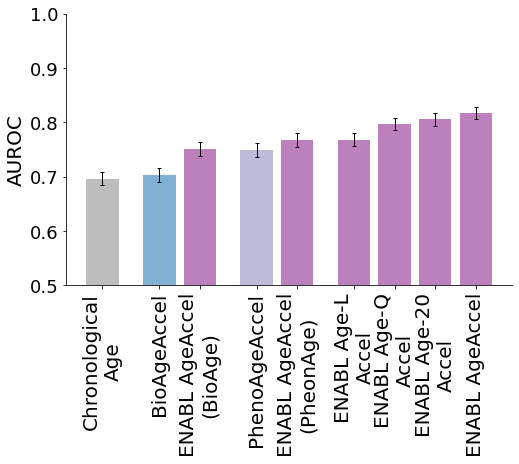

In [349]:
import numpy as np
import pylab as plt

fontsize = 18
plt.figure(figsize=(8,5))
plt.bar(y_pos, bincenters, width=0.8, color=color, yerr=[left_error,right_error], error_kw=dict(lw=1, capsize=2, capthick=1))
plt.xticks(y_pos, bars, rotation=90, fontsize=fontsize+2)
plt.ylabel('AUROC', fontsize=fontsize+2)
# plt.title(str(year)+'-year mortality prediction (Test set)', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim([0.5, 1])
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.savefig('./result/paper_figures/UKB_'+str(year)+'_mortality.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()

In [350]:
age_list = ['Age', 'BioAge_acc', 'shap_age_BioAge_acc', 'PhenoAge_acc', 'shap_age_PhenoAge_acc', \
            'shap_age_CBC_CMP_LP_WBC_acc', 'shap_age_Ques_Top20_acc', 'shap_age_Top20_acc', 'shap_age_acc']
bincenters = []
left_error = []
right_error = []
for age in age_list:
    bincenters.append(np.mean(result[age][str(year)+'_year_geo']['res']))
    left_error.append(np.mean(result[age][str(year)+'_year_geo']['res'])-result[age][str(year)+'_year_geo']['left_res'])
    right_error.append(result[age][str(year)+'_year_geo']['right_res']-np.mean(result[age][str(year)+'_year_geo']['res']))

In [351]:
print(len(age_list))

9


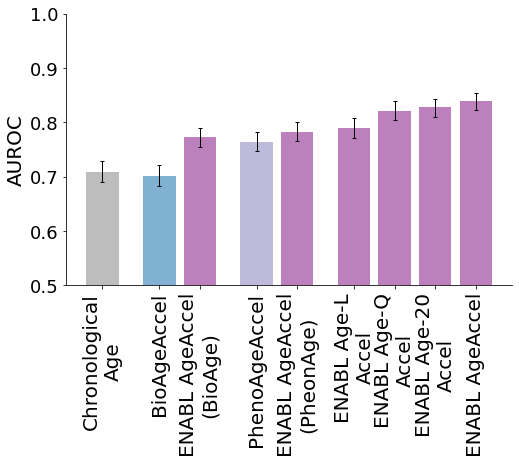

In [352]:
import numpy as np
import pylab as plt

fontsize = 18
plt.figure(figsize=(8,5))
plt.bar(y_pos, bincenters, width=0.8, color=color, yerr=[left_error,right_error], error_kw=dict(lw=1, capsize=2, capthick=1))
plt.xticks(y_pos, bars, rotation=90, fontsize=fontsize+2)
plt.ylabel('AUROC', fontsize=fontsize+2)
# plt.title(str(year)+'-year mortality prediction (Test set)', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim([0.5, 1])
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.savefig('./result/paper_figures/UKB_'+str(year)+'_mortality_GeoValidation.pdf', format='pdf', bbox_inches='tight', transparent=True)
plt.show()

In [338]:
### heatmap
### 'Age', 'BioAge', 'EXPECT Age\n(BioAge)', 'PhenoAge', 'EXPECT Age\n(PheonAge)', 'EXPECT Age-L', 'EXPECT Age-Q', 'EXPECT Age-20', 'EXPECT Age'
heat_map_label = np.array([
    [0, 0, 0, 1, 1, 1, 0, 1, 1,],  # CBC
    [0, 1, 1, 1, 1, 1, 0, 1, 1,],  # CMP
    [0, 1, 1, 0, 0, 1, 0, 0, 1,],  # LP
    [0, 0, 0, 1, 1, 1, 0, 1, 1,],  # WBC
    [0, 1, 1, 1, 1, 0, 0, 1, 1,],  # Other lab tests
    [0, 1, 1, 0, 0, 0, 1, 1, 1,],  # Physical measures
    [1, 0, 0, 0, 0, 0, 1, 1, 1,],  # Questionnaires
])
# BioAge: Hba1c
# Top20: Cystatin C, SHBG, Apolipoprotein A, Gamma glutamyltransferase

In [339]:
y_pos

array([0. , 1.4, 2.4, 3.8, 4.8, 6.2, 7.2, 8.2, 9.2])

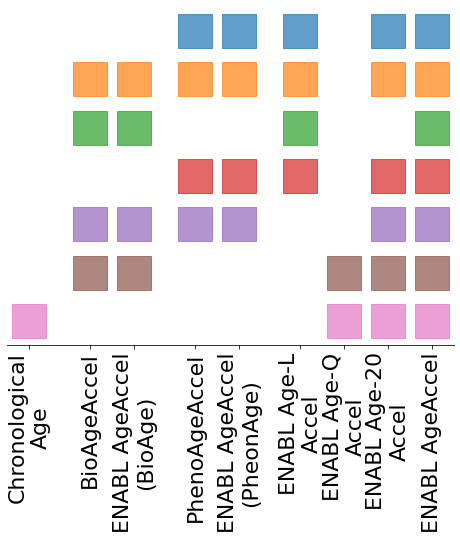

In [340]:
fontsize=18
width = 8
topx = 8
width_height_ratio = np.array(heat_map_label).shape[0]/np.array(heat_map_label).shape[1]
fig, ax = plt.subplots(1,1, figsize=(width, width*width_height_ratio)) 
pos_dict = dict(zip(np.arange(len(y_pos)), y_pos))
for idx in range(len(heat_map_label)):
    color_idxs = np.where(heat_map_label[idx])[0]
    ax.scatter([pos_dict[i] for i in color_idxs], [len(heat_map_label)-1-idx]*len(color_idxs), marker="s", s=(width/topx * 1100), alpha=0.7)
ax.set_xticks([pos_dict[i] for i in range(len(y_pos))])
# ax.set_yticks(np.arange(heat_map_label.shape[0]))
# ax.yaxis.tick_right()
ax.axes.yaxis.set_visible(False)

# # Set ticks labels for x-axis
# for i in np.arange(heat_map_label.shape[1]):
#     ax.axvline(pos_dict[i] + .5, alpha=1, c="#eeeeee")
# for i in np.arange(heat_map_label.shape[0]):
#     ax.axhline(i + .5, alpha=1, c="#eeeeee")
# ax.axvline(-.5, alpha=1, c="#eeeeee")


ax.set_xticklabels(['Chronological\nAge', 'BioAgeAccel', 'ENABL AgeAccel\n(BioAge)', 'PhenoAgeAccel', 'ENABL AgeAccel\n(PheonAge)', 
        'ENABL Age-L\nAccel', 'ENABL Age-Q\nAccel', 'ENABL Age-20\nAccel', 'ENABL AgeAccel'], rotation=90, fontsize=fontsize+4);

# ax.set_yticklabels(['CBC', 'CMP', 'LP', 'WBC', 'Other lab tests', 'Physical\nmeasures', 'Questionnaires'][::-1], rotation='horizontal', fontsize=20);
ax.set_ylim(-.5, heat_map_label.shape[0]-.5)
ax.set_xlim(-.5, max(y_pos)+0.5)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_facecolor('None')
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)

plt.savefig('./result/paper_figures/UKB_mortality_category.pdf', format='pdf', bbox_inches='tight', transparent=True)
im = plt.show()
# cbar = plt.colorbar(im) 

In [341]:
color_mapper = {
    'CBC': '#64a0cb',
    'CMP': '#ffa556', 
    'LP': '#6bbc6b', 
    'WBC': '#e26768', 
    'Other lab tests': '#b494d1', 
    'Physical\nmeasures': '#ae8881', 
    'Questionnaires': '#eba0d4'
}

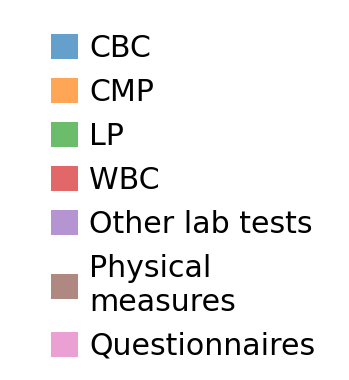

In [342]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=c, lw=5) for c in list(color_mapper.values())]
ax = plt.subplot()  #create the axes 
ax.set_axis_off()  #turn off the axis 
num_cols = int(np.ceil((len(color_mapper.keys()) + 1)/100))
num_cols=1

# ax.legend(custom_lines,  list(color_mapper.keys()), frameon=False, ncol=num_cols, prop={'size': 20})
handles, labels = plt.gca().get_legend_handles_labels()
custom_lines = [Line2D([0], [0], color=c, lw=25) for c in list(color_mapper.values())]
plt.legend(custom_lines,
           list(color_mapper.keys()), 
           handlelength=0.065, handleheight=0.8, frameon=False, prop={'size': 30})
plt.savefig('./result/paper_figures/mortality_category_legend.pdf', format='pdf', bbox_inches='tight')
plt.show() 

In [343]:
color_mapper = {
    'Chronological\nAge': '#bdbdbd',
    'BioAgeAccel': '#80b1d3', 
    'PhenoAgeAccel': '#bebada', 
    'ENABL AgeAccel': '#bc80bd', 
}

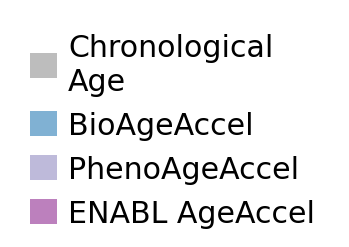

In [344]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=c, lw=5) for c in list(color_mapper.values())]
ax = plt.subplot()  #create the axes 
ax.set_axis_off()  #turn off the axis 
num_cols = int(np.ceil((len(color_mapper.keys()) + 1)/100))
num_cols=1

# ax.legend(custom_lines,  list(color_mapper.keys()), frameon=False, ncol=num_cols, prop={'size': 20})
handles, labels = plt.gca().get_legend_handles_labels()
custom_lines = [Line2D([0], [0], color=c, lw=25) for c in list(color_mapper.values())]
plt.legend(custom_lines,
           list(color_mapper.keys()), 
           handlelength=0.065, handleheight=0.8, frameon=False, prop={'size': 30})
plt.savefig('./result/paper_figures/mortality_barplot_legend.pdf', format='pdf', bbox_inches='tight')
plt.show() 

## EXPECT Age old version

In [ ]:
mortality = 'all-cause'
path = '/homes/gws/wqiu0528/uk_biobank_44562/result/IMPACT_Age_missforest/XGB_Cox_'+mortality+'_remove20002and20004_small_imputed_AgeAdjusted_CancerAdjusted_FloatAge_test_GeoValidation'
age_feature = 'Age'
gender_feature = '31-0.0'
random_state = 528
model_path = path+'/model.pickle.dat'
model_train = pickle.load(open(model_path, "rb"))
shap_age_obj_female = pickle.load(open(path+'/different_age_background/'+'female'+'/'+'SHAP_age_exponential'+'/'+'shap_age_object.pkl', 'rb'))
shap_age_obj_male = pickle.load(open(path+'/different_age_background/'+'male'+'/'+'SHAP_age_exponential'+'/'+'shap_age_object.pkl', 'rb'))

features = pd.read_csv('/projects/leelab/nobackup/wqiu/UK_Biobank_genetic_data/pheno_data/features_initial_preprocessing_missforest_imputed_no_missing_lancet_and_meaningful_adjusted_assays_remove20002and20004_AgeAdjusted_CancerAdjusted_geo.csv')
label_df = pd.read_csv('/projects/leelab/nobackup/wqiu/UK_Biobank_genetic_data/pheno_data/death_label.csv')
data_mortality = pd.merge(features, label_df[['eid', 'alive_year', mortality, 'external']], how='left', on='eid')        
X = data_mortality
X = X[(X[age_feature]>=39.5) & (X[age_feature]<=70.5)].reset_index(drop=True)  
X = X[(X['external']!=1)]
X = X[(X['all-cause']==0) | (X[mortality]==1)]
X_geo = X.loc[(X['54-0.0']==11004) | (X['54-0.0']==11005)].reset_index(drop=True)
X = X.loc[(X['54-0.0']!=11004) & (X['54-0.0']!=11005)].reset_index(drop=True)
mortstat = X['all-cause'].reset_index(drop=True)
permth_int = X['alive_year'].reset_index(drop=True)
mortstat_geo = X_geo[mortality].reset_index(drop=True)
permth_int_geo = X_geo['alive_year'].reset_index(drop=True)
print('# samples: ', X.shape[0])
print('# positive samples: ', sum(X[mortality]==1))
print('# negative samples: ', sum(X[mortality]==0))
print('# features: ', X.shape[1])

X_train, X_test, _, _ = train_test_split(X, X, test_size=0.2, random_state=random_state)
# X_train, X_val, _, _ = train_test_split(X_train, X_train, test_size=0.1, random_state=random_state)
print(X_train.index)

file = open("./feature_names_dictionary_DateToAge.pkl", "rb")
col_dict = pickle.load(file)
file.close()
display_col=[]
for col in X_train.columns:
    if col in col_dict:
        display_col.append(col_dict[col])
    else:
        display_col.append(col)

In [ ]:
year = 5
train_label_5 = np.array([label_all(np.array(X_train['alive_year'])[j], np.array(X_train[mortality])[j], year) for j in range(len(X_train))])
# val_label_5 = np.array([label_all(np.array(X_val['alive_year'])[j], np.array(X_val[mortality])[j], year) for j in range(len(X_val))])
test_label_5 = np.array([label_all(np.array(X_test['alive_year'])[j], np.array(X_test[mortality])[j], year) for j in range(len(X_test))])
geo_label_5 = np.array([label_all(np.array(X_geo['alive_year'])[j], np.array(X_geo[mortality])[j], year) for j in range(len(X_geo))])

In [ ]:
year = 10
train_label_10 = np.array([label_all(np.array(X_train['alive_year'])[j], np.array(X_train[mortality])[j], year) for j in range(len(X_train))])
# val_label_10 = np.array([label_all(np.array(X_val['alive_year'])[j], np.array(X_val[mortality])[j], year) for j in range(len(X_val))])
test_label_10 = np.array([label_all(np.array(X_test['alive_year'])[j], np.array(X_test[mortality])[j], year) for j in range(len(X_test))])
geo_label_10 = np.array([label_all(np.array(X_geo['alive_year'])[j], np.array(X_geo[mortality])[j], year) for j in range(len(X_geo))])

In [ ]:
X_train['shap_age'] = None
fore_prediction_female = model_train.predict(X_train.loc[X_train[gender_feature]==0, model_train.get_booster().feature_names], output_margin=True)
X_train.loc[X_train[gender_feature]==0, 'shap_age'] = np.array([shap_age_obj_female.get_shap_age(fore_prediction_female[i]) for i in range(len(fore_prediction_female))])
fore_prediction_male = model_train.predict(X_train.loc[X_train[gender_feature]==1, model_train.get_booster().feature_names], output_margin=True)
X_train.loc[X_train[gender_feature]==1, 'shap_age'] = np.array([shap_age_obj_male.get_shap_age(fore_prediction_male[i]) for i in range(len(fore_prediction_male))])
X_train['shap_age_acc'] = X_train['shap_age']-X_train['Age']

In [ ]:
# X_val['shap_age'] = None
# fore_prediction_female = model_train.predict(X_val.loc[X_val[gender_feature]==0, model_train.get_booster().feature_names], output_margin=True)
# X_val.loc[X_val[gender_feature]==0, 'shap_age'] = np.array([shap_age_obj_female.get_shap_age(fore_prediction_female[i]) for i in range(len(fore_prediction_female))])
# fore_prediction_male = model_train.predict(X_val.loc[X_val[gender_feature]==1, model_train.get_booster().feature_names], output_margin=True)
# X_val.loc[X_val[gender_feature]==1, 'shap_age'] = np.array([shap_age_obj_male.get_shap_age(fore_prediction_male[i]) for i in range(len(fore_prediction_male))])
# X_val['shap_age_acc'] = X_val['shap_age']-X_val['Age']

In [ ]:
X_test['shap_age'] = None
fore_prediction_female = model_train.predict(X_test.loc[X_test[gender_feature]==0, model_train.get_booster().feature_names], output_margin=True)
X_test.loc[X_test[gender_feature]==0, 'shap_age'] = np.array([shap_age_obj_female.get_shap_age(fore_prediction_female[i]) for i in range(len(fore_prediction_female))])
fore_prediction_male = model_train.predict(X_test.loc[X_test[gender_feature]==1, model_train.get_booster().feature_names], output_margin=True)
X_test.loc[X_test[gender_feature]==1, 'shap_age'] = np.array([shap_age_obj_male.get_shap_age(fore_prediction_male[i]) for i in range(len(fore_prediction_male))])
X_test['shap_age_acc'] = X_test['shap_age']-X_test['Age']

In [ ]:
X_geo['shap_age'] = None
fore_prediction_female = model_train.predict(X_geo.loc[X_geo[gender_feature]==0, model_train.get_booster().feature_names], output_margin=True)
X_geo.loc[X_geo[gender_feature]==0, 'shap_age'] = np.array([shap_age_obj_female.get_shap_age(fore_prediction_female[i]) for i in range(len(fore_prediction_female))])
fore_prediction_male = model_train.predict(X_geo.loc[X_geo[gender_feature]==1, model_train.get_booster().feature_names], output_margin=True)
X_geo.loc[X_geo[gender_feature]==1, 'shap_age'] = np.array([shap_age_obj_male.get_shap_age(fore_prediction_male[i]) for i in range(len(fore_prediction_male))])
X_geo['shap_age_acc'] = X_geo['shap_age']-X_geo['Age']

In [ ]:
result['shap_age'] = {}

In [ ]:
year = 5
train_label_5_temp = train_label_5[X_train['shap_age']!=np.inf]
X_train_temp = X_train[X_train['shap_age']!=np.inf]
# val_label_5_temp = val_label_5[X_val['shap_age']!=np.inf]
# X_val = X_val[X_val['shap_age']!=np.inf]
test_label_5_temp = test_label_5[X_test['shap_age']!=np.inf]
X_test_temp = X_test[X_test['shap_age']!=np.inf]
geo_label_5_temp = geo_label_5[X_geo['shap_age']!=np.inf]
X_geo_temp = X_geo[X_geo['shap_age']!=np.inf]

In [ ]:
# 5-year mortality, chronological age + biological age acc + Gender
feature_list = [age_feature, 'shap_age_acc', gender_feature]
# _, xgb_model = val_mortality_model(X_train_temp[feature_list], X_val_temp[feature_list], X_test_temp[feature_list], train_label_5_temp, val_label_5_temp, test_label_5_temp)
_, xgb_model = val_mortality_model(X_train_temp[feature_list], X_test_temp[feature_list], train_label_5_temp, test_label_5_temp)
res, left_res, right_res = bootstrap_ci(xgb_model.predict_proba(np.array(X_test_temp[feature_list]))[:, 1], test_label_5_temp, len(X_test_temp), repetitions = 1000, alpha = 0.05, metric='AUC')
result['shap_age']['5_year_test'] = {'res': res, 'left_res': left_res, 'right_res': right_res}
res, left_res, right_res = bootstrap_ci(xgb_model.predict_proba(np.array(X_geo_temp[feature_list]))[:, 1], geo_label_5_temp, len(X_geo_temp), repetitions = 1000, alpha = 0.05, metric='AUC')
result['shap_age']['5_year_geo'] = {'res': res, 'left_res': left_res, 'right_res': right_res}

In [ ]:
year = 10
train_label_10_temp = train_label_10[X_train['shap_age']!=np.inf]
X_train_temp = X_train[X_train['shap_age']!=np.inf]
# val_label_10_temp = val_label_10[X_val['shap_age']!=np.inf]
# X_val = X_val[X_val['shap_age']!=np.inf]
test_label_10_temp = test_label_10[X_test['shap_age']!=np.inf]
X_test_temp = X_test[X_test['shap_age']!=np.inf]
geo_label_10_temp = geo_label_10[X_geo['shap_age']!=np.inf]
X_geo_temp = X_geo[X_geo['shap_age']!=np.inf]

In [ ]:
# 10-year mortality, chronological age + biological age acc + Gender
feature_list = [age_feature, 'shap_age_acc', gender_feature]
# _, xgb_model = val_mortality_model(X_train[feature_list], X_val[feature_list], X_test[feature_list], train_label_10, val_label_10, test_label_10)
_, xgb_model = val_mortality_model(X_train[feature_list], X_test[feature_list], train_label_10, test_label_10)
res, left_res, right_res = bootstrap_ci(xgb_model.predict_proba(np.array(X_test[feature_list]))[:, 1], test_label_10, len(X_test), repetitions = 1000, alpha = 0.05, metric='AUC')
result['shap_age']['10_year_test'] = {'res': res, 'left_res': left_res, 'right_res': right_res}
res, left_res, right_res = bootstrap_ci(xgb_model.predict_proba(np.array(X_geo[feature_list]))[:, 1], geo_label_10, len(X_geo), repetitions = 1000, alpha = 0.05, metric='AUC')
result['shap_age']['10_year_geo'] = {'res': res, 'left_res': left_res, 'right_res': right_res}